In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coco-2017-dataset/coco2017/val2017/000000011197.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000219485.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000151000.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000371677.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000038825.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000384527.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000122969.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000028809.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000053505.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000384513.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000356531.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000106563.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000125257.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000259571.jpg
/kaggle/input/coco-2017-dataset/coco2017/val2017/000000568690.jpg
/kaggle/in

In [2]:
!pip install transformers torch torchvision datasets
!pip install opencv-python-headless Pillow matplotlib seaborn
!pip install sentence-transformers 
!pip install pycocotools
!pip install gradio ipywidgets
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path
from transformers import AutoTokenizer, AutoModel, CLIPProcessor, CLIPModel
import gradio as gr
from typing import List, Tuple, Dict
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# **Data Pre-Processing**

In [6]:
class COCOSceneLocalizationDataset(Dataset):
    def __init__(self, 
                 root_dir="/kaggle/input/coco-2017-dataset/coco2017", 
                 split="train", 
                 transform=None, 
                 max_length=128,
                 max_samples=None):
        """
        COCO Dataset for Scene Localization
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.max_length = max_length
        
        if split == "train":
            self.img_dir = self.root_dir / "train2017"
            self.ann_file = self.root_dir / "annotations" / "instances_train2017.json"
        elif split == "val":
            self.img_dir = self.root_dir / "val2017" 
            self.ann_file = self.root_dir / "annotations" / "instances_val2017.json"
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        print(f"Loading COCO annotations from {self.ann_file}")
        self.coco = COCO(str(self.ann_file))
    
        self.img_ids = list(self.coco.imgs.keys())
        
        self.img_ids = [img_id for img_id in self.img_ids 
                       if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        if max_samples:
            self.img_ids = self.img_ids[:max_samples]
        
        self.categories = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}
        
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        
        self.create_queries()
        
        print(f"Loaded {len(self.img_ids)} images with {len(self.categories)} categories")
    
    def create_queries(self):
        """Create natural language queries from COCO categories"""
        self.query_templates = [
            "a {category}",
            "person with {category}",
            "someone using {category}",
            "{category} in the scene",
            "find the {category}",
            "locate {category}",
            "show me {category}",
            "{category} object",
            "person wearing {category}"
        ]
        #to add more query templates
    
    def __len__(self):
        return len(self.img_ids)
    
    def normalize_bbox(self, bbox, img_width, img_height):
        """Convert COCO bbox [x, y, width, height] to normalized [x1, y1, x2, y2]"""
        x, y, w, h = bbox
        x1 = x / img_width
        y1 = y / img_height
        x2 = (x + w) / img_width
        y2 = (y + h) / img_height
        
        # Ensure bbox is within [0, 1]
        x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, 1)
        
        return [x1, y1, x2, y2]
    
    def generate_query(self, category_name):
        template = random.choice(self.query_templates)
        return template.format(category=category_name)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        
        image = Image.open(img_path).convert('RGB')
        img_width, img_height = img_info['width'], img_info['height']
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        valid_anns = [ann for ann in anns if ann['area'] > 1000 and not ann['iscrowd']]
        
        if not valid_anns:
            valid_anns = anns[:1] if anns else []
        
        if not valid_anns:
            valid_anns = [{
                'bbox': [0, 0, img_width//2, img_height//2],
                'category_id': 1,
                'area': (img_width//2) * (img_height//2)
            }]
        
        ann = random.choice(valid_anns)
        
        category_id = ann['category_id']
        category_name = self.categories.get(category_id, 'object')
        query = self.generate_query(category_name)
        
        bbox = self.normalize_bbox(ann['bbox'], img_width, img_height)
        
        if self.transform:
            image = self.transform(image)
        
        tokens = self.tokenizer(
            query,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'bbox': torch.tensor(bbox, dtype=torch.float32),
            'query': query,
            'category': category_name,
            'image_id': img_id,
            'file_name': img_info['file_name']
        }

try:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = COCOSceneLocalizationDataset(
        split="val", 
        transform=transform, 
        max_samples=10
    )
    
    print(f"loaded {len(test_dataset)} samples")
    
    sample = test_dataset[0]
    print(f"Sample query: '{sample['query']}'")
    print(f"Sample bbox: {sample['bbox']}")
    print(f"Sample category: {sample['category']}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the COCO dataset is properly mounted in Kaggle")


Loading COCO annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
Loaded 10 images with 80 categories
loaded 10 samples
Sample query: 'show me bowl'
Sample bbox: tensor([0.0932, 0.6730, 0.2120, 0.7697])
Sample category: bowl


# Model Architecture

In [ ]:
class AdvancedCrossModalFusion(nn.Module):
    def __init__(self, visual_dim, text_dim, hidden_dim=512, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        #project to common dimension
        self.visual_proj = nn.Linear(visual_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        
        #Multi-head cross-attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )
        
        #Self-attention for visual features
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )
        
        #layernorm
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
        
        #fnn
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(0.1)
        )
        
    def forward(self, visual_features, text_features):
        batch_size = visual_features.size(0)
        
        #project to common space
        visual_proj = self.visual_proj(visual_features)  
        text_proj = self.text_proj(text_features)        
        
        #Self-attention on visual features
        visual_self, _ = self.self_attention(visual_proj, visual_proj, visual_proj)
        visual_self = self.ln1(visual_proj + visual_self)
        
        #cross-modal attention: visual queries, text keys/values
        cross_attended, attention_weights = self.cross_attention(
            query=visual_self,
            key=text_proj,
            value=text_proj
        )
        
        #residual connection and layer norm
        fused = self.ln2(visual_self + cross_attended)
        
        #fnn
        ffn_out = self.ffn(fused)
        output = self.ln3(fused + ffn_out)
        
        return output, attention_weights

class EnhancedSceneLocalizationModel(nn.Module):
    def __init__(self, num_classes=80):  
        super().__init__()
        
        #pre-trained CLIP model
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        #freeze CLIP parameters initially
        for param in self.clip_model.parameters():
            param.requires_grad = False
        
        #unfreezed last few layers for fine-tuning
        for param in self.clip_model.vision_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
        for param in self.clip_model.text_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
        
        visual_dim = self.clip_model.config.vision_config.hidden_size  # 768
        text_dim = self.clip_model.config.text_config.hidden_size      # 512
        
        #enhanced cross-modal fusion
        self.fusion = AdvancedCrossModalFusion(visual_dim, text_dim, hidden_dim=512)
        
        #spatial pooling for different scales
        self.adaptive_pools = nn.ModuleList([
            nn.AdaptiveAvgPool1d(1),
            nn.AdaptiveMaxPool1d(1),
            nn.AdaptiveAvgPool1d(4),
        ])
        
        #localization head with multiple scales
        self.localization_head = nn.Sequential(
            nn.Linear(512 * 6, 1024),  
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4) 
        )
        
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        self.confidence_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, images, input_ids, attention_mask):
        batch_size = images.size(0)
        
        vision_outputs = self.clip_model.vision_model(pixel_values=images)
        visual_features = vision_outputs.last_hidden_state
        
        text_outputs = self.clip_model.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_features = text_outputs.last_hidden_state  
        
        fused_features, attention_weights = self.fusion(visual_features, text_features)
        
        pooled_features = []
        fused_transposed = fused_features.transpose(1, 2) 
        
        for pool in self.adaptive_pools:
            pooled = pool(fused_transposed).flatten(1)
            pooled_features.append(pooled)
        
        multi_scale_features = torch.cat(pooled_features, dim=1)
        
        bbox_pred = self.localization_head(multi_scale_features)
        bbox_pred = torch.sigmoid(bbox_pred) 
        
        class_pred = self.classification_head(fused_features.transpose(1, 2))
        confidence = self.confidence_head(fused_features.transpose(1, 2))
        
        return bbox_pred, class_pred, confidence, attention_weights

model = EnhancedSceneLocalizationModel()
model = model.to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")


# Loss Function

In [8]:
class AdvancedLocalizationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth_l1 = nn.SmoothL1Loss()
        self.mse = nn.MSELoss()
        
    def generalized_iou_loss(self, pred_boxes, target_boxes):
        pred_x1, pred_y1, pred_x2, pred_y2 = pred_boxes.unbind(dim=-1)
        target_x1, target_y1, target_x2, target_y2 = target_boxes.unbind(dim=-1)

        inter_x1 = torch.max(pred_x1, target_x1)
        inter_y1 = torch.max(pred_y1, target_y1)
        inter_x2 = torch.min(pred_x2, target_x2)
        inter_y2 = torch.min(pred_y2, target_y2)
        
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
        
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
        union_area = pred_area + target_area - inter_area + 1e-7
        
        enclose_x1 = torch.min(pred_x1, target_x1)
        enclose_y1 = torch.min(pred_y1, target_y1)
        enclose_x2 = torch.max(pred_x2, target_x2)
        enclose_y2 = torch.max(pred_y2, target_y2)
        enclose_area = (enclose_x2 - enclose_x1) * (enclose_y2 - enclose_y1) + 1e-7
        
        #IoU and GIoU
        iou = inter_area / union_area
        giou = iou - (enclose_area - union_area) / enclose_area
        
        return 1 - giou.mean()
    
    def focal_loss(self, pred_boxes, target_boxes, alpha=0.25, gamma=2.0):
        iou = self.calculate_iou(pred_boxes, target_boxes)
        pt = iou
        focal_weight = alpha * (1 - pt) ** gamma
        return focal_weight * (1 - iou).mean()
    
    def forward(self, pred_boxes, target_boxes, pred_center=None, pred_size=None):
        smooth_l1_loss = self.smooth_l1(pred_boxes, target_boxes)
        giou_loss = self.generalized_iou_loss(pred_boxes, target_boxes)
        focal_loss = self.focal_loss(pred_boxes, target_boxes)
        
        total_loss = smooth_l1_loss + 2.0 * giou_loss + 0.5 * focal_loss
        
        if pred_center is not None and pred_size is not None:
            target_center = torch.stack([
                (target_boxes[:, 0] + target_boxes[:, 2]) / 2,
                (target_boxes[:, 1] + target_boxes[:, 3]) / 2
            ], dim=1)
            target_size = torch.stack([
                target_boxes[:, 2] - target_boxes[:, 0],
                target_boxes[:, 3] - target_boxes[:, 1]
            ], dim=1)
            
            center_loss = self.mse(pred_center, target_center)
            size_loss = self.mse(pred_size, target_size)
            
            total_loss += 0.5 * center_loss + 0.5 * size_loss
        
        return total_loss


# Trainer Setup

In [10]:
class COCOSceneLocalizationTrainer:
    def __init__(self, model, device=device):
        self.model = model.to(device)
        self.device = device
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        #loss functions with weights
        self.bbox_loss = nn.SmoothL1Loss()
        self.classification_loss = nn.CrossEntropyLoss()
        self.confidence_loss = nn.BCELoss()
        
        #loss weights
        self.bbox_weight = 2.0
        self.class_weight = 1.0
        self.confidence_weight = 0.5
        
        backbone_params = []
        head_params = []
        
        for name, param in model.named_parameters():
            if 'clip_model' in name:
                backbone_params.append(param)
            else:
                head_params.append(param)
        
        self.optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},  
            {'params': head_params, 'lr': 1e-4}       
        ], weight_decay=1e-4)
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2
        )
        
        self.train_losses = []
        self.val_losses = []
        self.train_ious = []
        self.val_ious = []
        
    def compute_iou(self, pred_boxes, target_boxes, epsilon=1e-6):
        pred_x1, pred_y1, pred_x2, pred_y2 = pred_boxes.unbind(dim=-1)
        target_x1, target_y1, target_x2, target_y2 = target_boxes.unbind(dim=-1)
        
        inter_x1 = torch.max(pred_x1, target_x1)
        inter_y1 = torch.max(pred_y1, target_y1)
        inter_x2 = torch.min(pred_x2, target_x2)
        inter_y2 = torch.min(pred_y2, target_y2)
        
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
        
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
        union_area = pred_area + target_area - inter_area + epsilon
        
        iou = inter_area / union_area
        return iou
    
    def process_batch(self, batch):
        """Process a batch of data"""
        images = []
        texts = []
        
        for i in range(len(batch['image'])):
            img_tensor = batch['image'][i]
            if img_tensor.dim() == 3:
                img_array = img_tensor.permute(1, 2, 0).numpy()
                img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)
                pil_image = Image.fromarray(img_array)
                images.append(pil_image)
            texts.append(batch['query'][i])
        
        inputs = self.clip_processor(
            text=texts,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        
        return {
            'pixel_values': inputs['pixel_values'].to(self.device),
            'input_ids': inputs['input_ids'].to(self.device),
            'attention_mask': inputs['attention_mask'].to(self.device),
            'bbox': batch['bbox'].to(self.device)
        }
    
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        total_bbox_loss = 0
        total_iou = 0
        num_batches = 0
        
        progress_bar = tqdm(dataloader, desc="Training")
        
        for batch in progress_bar:
            try:
                processed_batch = self.process_batch(batch)
                
                bbox_pred, class_pred, confidence, attention_weights = self.model(
                    processed_batch['pixel_values'],
                    processed_batch['input_ids'],
                    processed_batch['attention_mask']
                )
                
                bbox_loss = self.bbox_loss(bbox_pred, processed_batch['bbox'])
                
                confidence_targets = torch.ones(bbox_pred.size(0), 1).to(self.device)
                conf_loss = self.confidence_loss(confidence, confidence_targets)
                
                total_batch_loss = (
                    self.bbox_weight * bbox_loss + 
                    self.confidence_weight * conf_loss
                )
                
                self.optimizer.zero_grad()
                total_batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                with torch.no_grad():
                    iou = self.compute_iou(bbox_pred, processed_batch['bbox']).mean()
                    total_iou += iou.item()
                
                total_loss += total_batch_loss.item()
                total_bbox_loss += bbox_loss.item()
                num_batches += 1
                
                progress_bar.set_postfix({
                    'Loss': f"{total_batch_loss.item():.4f}",
                    'IoU': f"{iou.item():.4f}"
                })
                
            except Exception as e:
                print(f"Error in batch: {e}")
                continue
        
        self.scheduler.step()
        
        metrics = {
            'loss': total_loss / max(num_batches, 1),
            'bbox_loss': total_bbox_loss / max(num_batches, 1),
            'iou': total_iou / max(num_batches, 1),
            'lr': self.scheduler.get_last_lr()[0]
        }
        
        self.train_losses.append(metrics['loss'])
        self.train_ious.append(metrics['iou'])
        
        return metrics
    
    def validate(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_iou = 0
        num_batches = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation"):
                try:
                    processed_batch = self.process_batch(batch)
                    
                    bbox_pred, class_pred, confidence, attention_weights = self.model(
                        processed_batch['pixel_values'],
                        processed_batch['input_ids'],
                        processed_batch['attention_mask']
                    )
                    
                    bbox_loss = self.bbox_loss(bbox_pred, processed_batch['bbox'])
                    iou = self.compute_iou(bbox_pred, processed_batch['bbox']).mean()
                    
                    total_loss += bbox_loss.item()
                    total_iou += iou.item()
                    num_batches += 1
                    
                except Exception as e:
                    continue
        
        metrics = {
            'val_loss': total_loss / max(num_batches, 1),
            'val_iou': total_iou / max(num_batches, 1)
        }
        
        self.val_losses.append(metrics['val_loss'])
        self.val_ious.append(metrics['val_iou'])
        
        return metrics

def collate_fn(batch):
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'bbox': torch.stack([item['bbox'] for item in batch]),
        'query': [item['query'] for item in batch],
        'category': [item['category'] for item in batch],
        'image_id': [item['image_id'] for item in batch],
        'file_name': [item['file_name'] for item in batch]
    }




# Training

In [ ]:
def setup_datasets_and_training():
    
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = COCOSceneLocalizationDataset(
        split="train",
        transform=train_transform,
        max_samples=2500  
    )
    
    val_dataset = COCOSceneLocalizationDataset(
        split="val",
        transform=val_transform,
        max_samples=250 
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,  
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset, val_dataset

def train_model(model, train_loader, val_loader, num_epochs=10):
    
    trainer = COCOSceneLocalizationTrainer(model)
    
    best_val_iou = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        train_metrics = trainer.train_epoch(train_loader)
        
        val_metrics = trainer.validate(val_loader)
        
        print(f"Train - Loss: {train_metrics['loss']:.4f}, IoU: {train_metrics['iou']:.4f}")
        print(f"Val   - Loss: {val_metrics['val_loss']:.4f}, IoU: {val_metrics['val_iou']:.4f}")
        print(f"LR: {train_metrics['lr']:.6f}")
        
        if val_metrics['val_iou'] > best_val_iou:
            best_val_iou = val_metrics['val_iou']
            best_model_state = model.state_dict().copy()
            print(f"New best validation IoU: {best_val_iou:.4f}")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\nTraining completed. Best validation IoU: {best_val_iou:.4f}")
    
    return trainer

try:
    train_loader, val_loader, train_dataset, val_dataset = setup_datasets_and_training()
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    trainer = train_model(model, train_loader, val_loader, num_epochs=10)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Val Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_ious, label='Train IoU')
    plt.plot(trainer.val_ious, label='Val IoU')
    plt.title('Training IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in training setup: {e}")


# Post Processing Inference

In [13]:
class COCOSceneLocalizationInference:
    def __init__(self, model, device=device):
        self.model = model.to(device)
        self.device = device
        self.model.eval()
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
    def predict(self, image, query):
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
        elif isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        inputs = self.clip_processor(
            text=[query],
            images=[image],
            return_tensors="pt",
            padding=True
        )
        
        pixel_values = inputs['pixel_values'].to(self.device)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)
        
        with torch.no_grad():
            bbox_pred, class_pred, confidence, attention_weights = self.model(
                pixel_values, input_ids, attention_mask
            )
        
        bbox = bbox_pred[0].cpu().numpy()
        conf = confidence[0].cpu().numpy()[0]
        
        return bbox, conf, attention_weights[0].cpu().numpy()
    
    def visualize_prediction(self, image, query, bbox, confidence=None, save_path=None):
        if isinstance(image, str):
            original_image = Image.open(image).convert('RGB')
        elif isinstance(image, np.ndarray):
            original_image = Image.fromarray(image)
        else:
            original_image = image
        
        img_array = np.array(original_image)
        h, w = img_array.shape[:2]
        
        x1, y1, x2, y2 = bbox
        x1, x2 = int(x1 * w), int(x2 * w)
        y1, y2 = int(y1 * h), int(y2 * h)
        
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        img_with_bbox = img_array.copy()
        cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
        
        label = f"{query}"
        if confidence is not None:
            label += f" (conf: {confidence:.3f})"
        
        font_scale = 0.7
        thickness = 2
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        
        cv2.rectangle(img_with_bbox, (x1, y1-text_height-10), (x1+text_width, y1), (0, 255, 0), -1)
        cv2.putText(img_with_bbox, label, (x1, y1-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(img_array)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(img_with_bbox)
        axes[1].set_title(f'Prediction: "{query}"')
        axes[1].axis('off')
        
        if x2 > x1 and y2 > y1:
            cropped_region = img_array[y1:y2, x1:x2]
            axes[2].imshow(cropped_region)
            axes[2].set_title('Cropped Region')
        else:
            axes[2].text(0.5, 0.5, 'Invalid bbox', ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('Cropped Region (Invalid)')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()
        
        return img_with_bbox, cropped_region if x2 > x1 and y2 > y1 else None

inference_system = COCOSceneLocalizationInference(model)



# Demo Visualization

Sample queries you can try:
1. person
2. car
3. bicycle
4. dog
5. cat
6. chair
7. dining table
8. laptop
9. cell phone
10. book
Demo function created!
Testing with validation samples...
Loading COCO annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Loaded 5 images with 80 categories

Test 1:
Query: 'find the bottle'
Category: bottle
Ground truth bbox: tensor([0.3400, 0.5633, 0.4010, 0.6986])
Predicted bbox: [0.44636405 0.4270733  0.55793124 0.5750308 ]
Confidence: 1.000


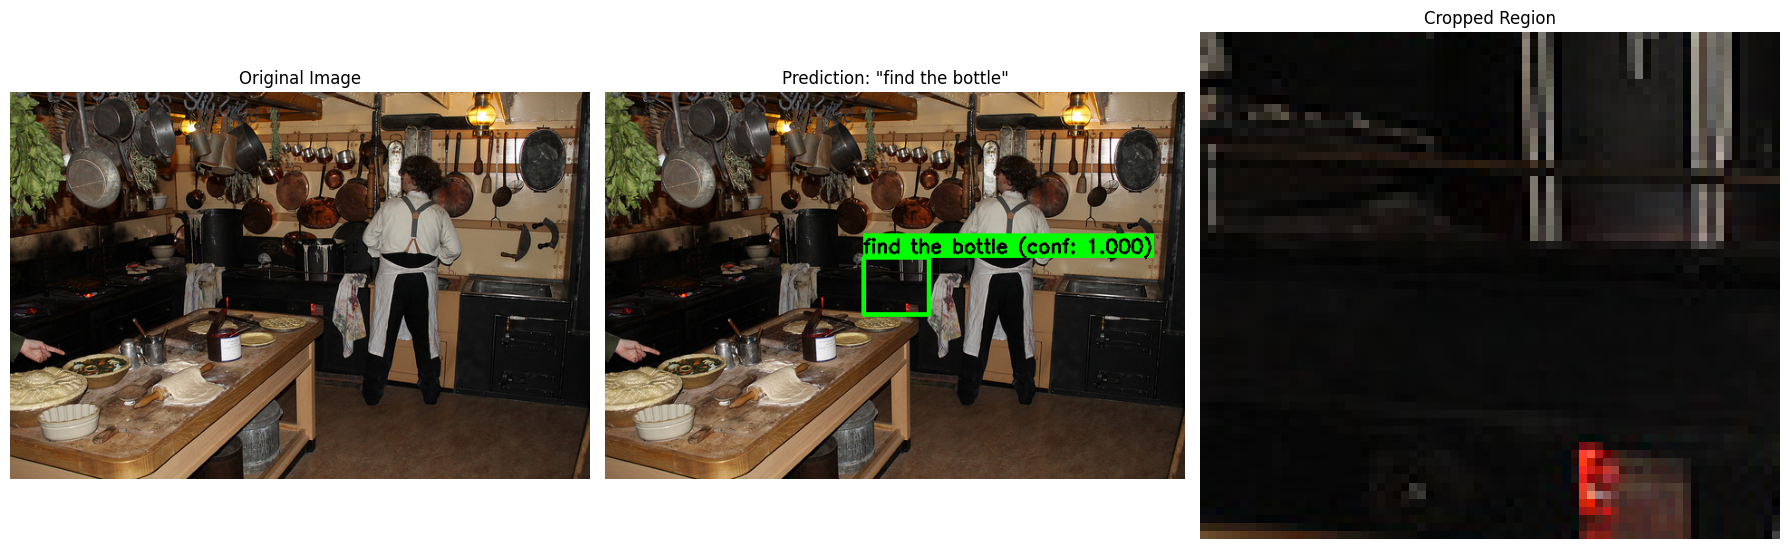


Test 2:
Query: 'a oven'
Category: oven
Ground truth bbox: tensor([0.3905, 0.5396, 0.5615, 0.8484])
Predicted bbox: [0.414996   0.592579   0.62788486 0.8160478 ]
Confidence: 1.000


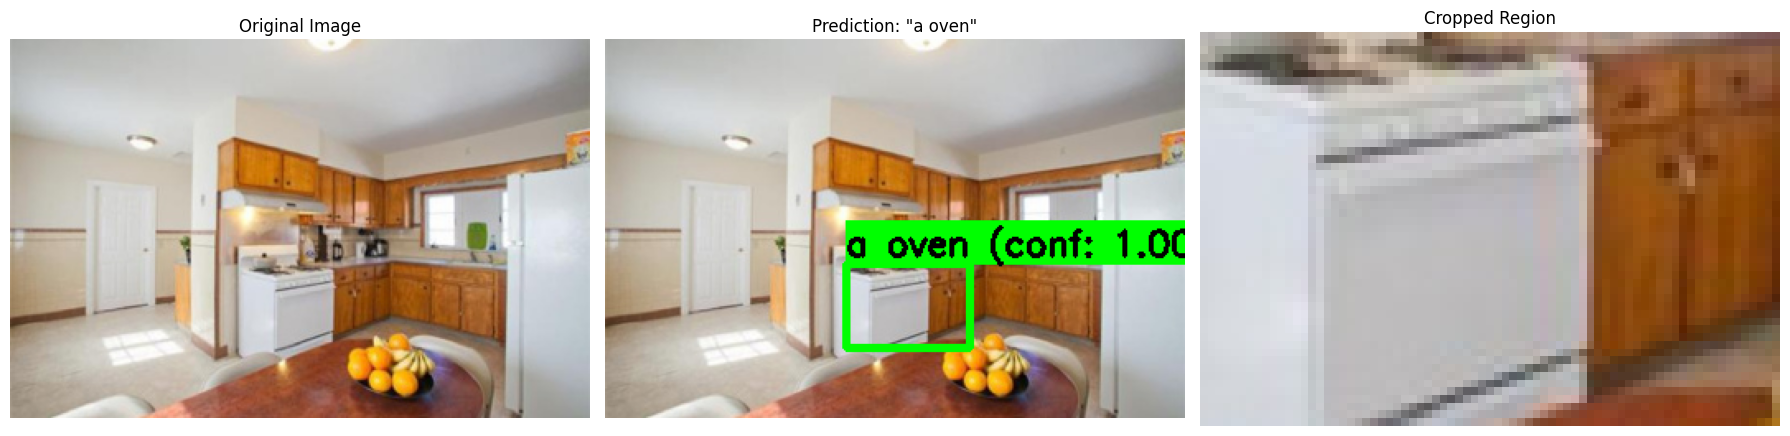


Test 3:
Query: 'person object'
Category: person
Ground truth bbox: tensor([0.0153, 0.3903, 0.2058, 0.9194])
Predicted bbox: [0.4016462  0.46582466 0.57949555 0.75779396]
Confidence: 1.000


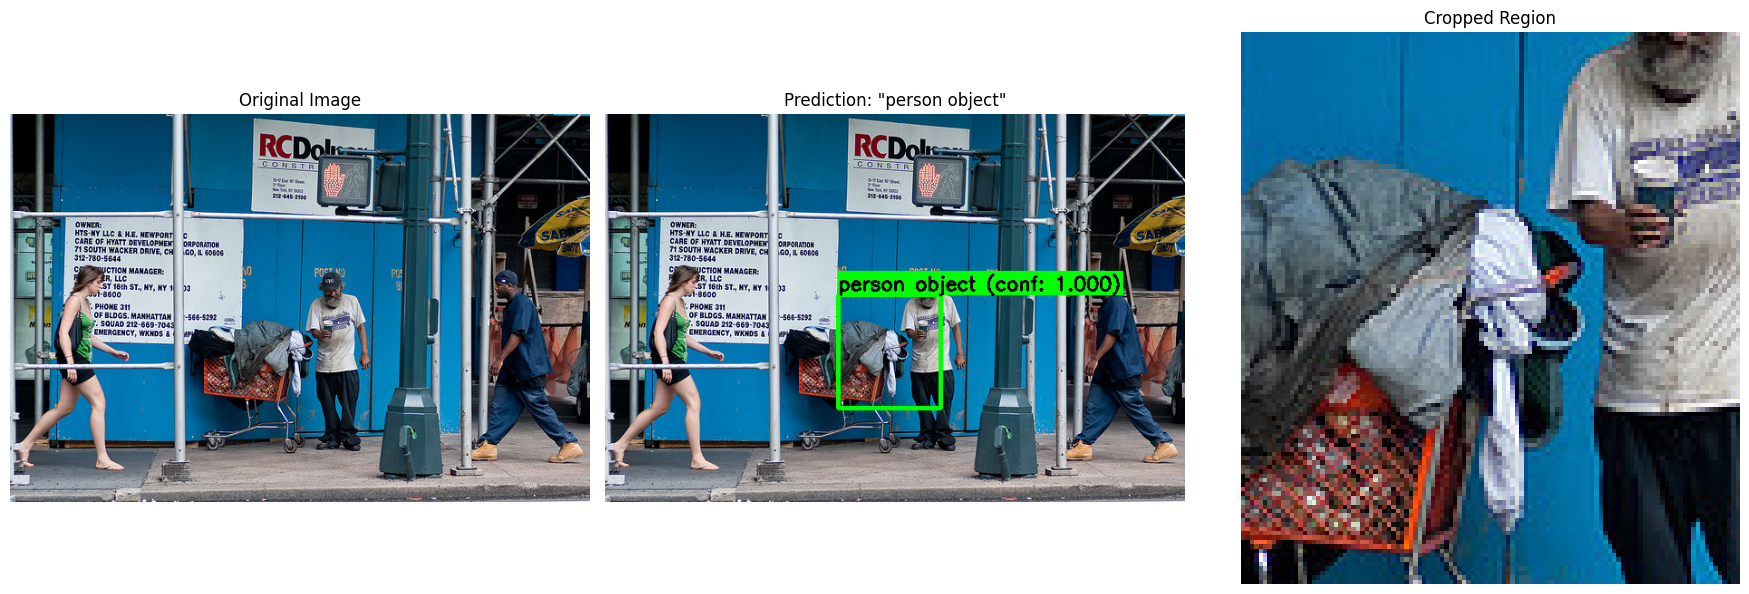


Test 4:
Query: 'locate skateboard'
Category: skateboard
Ground truth bbox: tensor([0.4666, 0.6601, 0.5664, 0.7584])
Predicted bbox: [0.40625042 0.5447742  0.60715556 0.73559314]
Confidence: 1.000


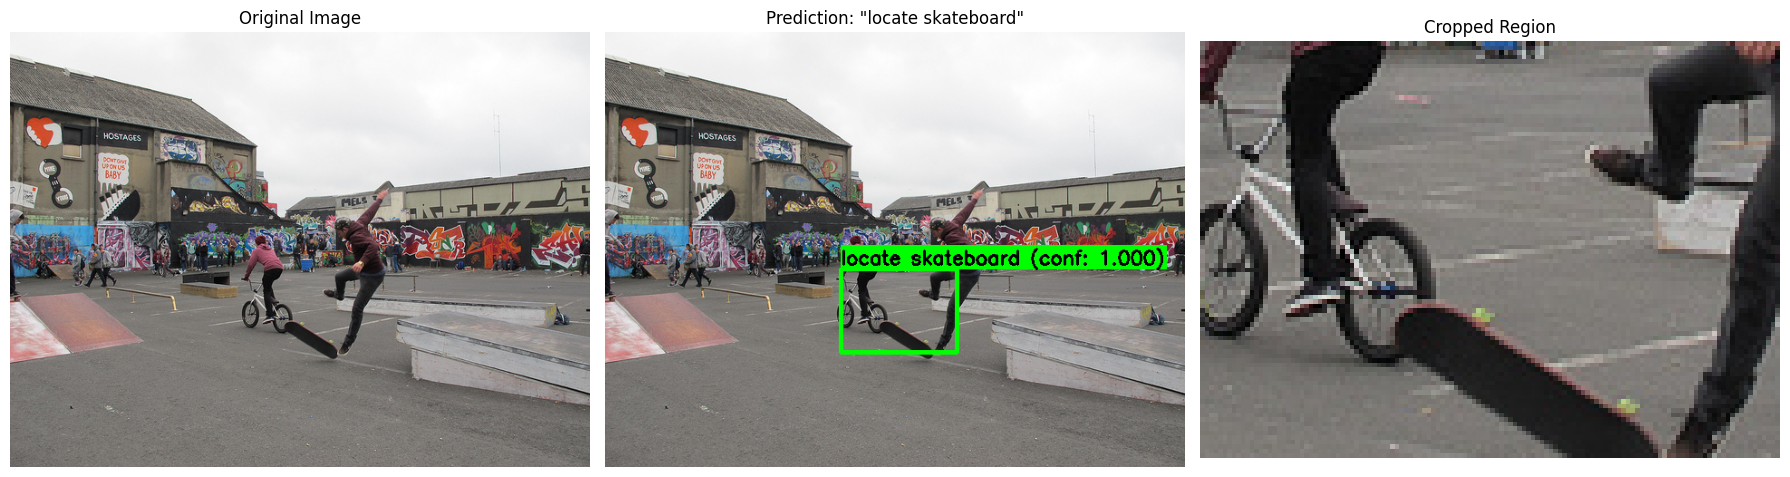


Test 5:
Query: 'a truck'
Category: truck
Ground truth bbox: tensor([0.7907, 0.0651, 1.0000, 0.3537])
Predicted bbox: [0.18340012 0.11556901 0.8086466  0.7475094 ]
Confidence: 1.000


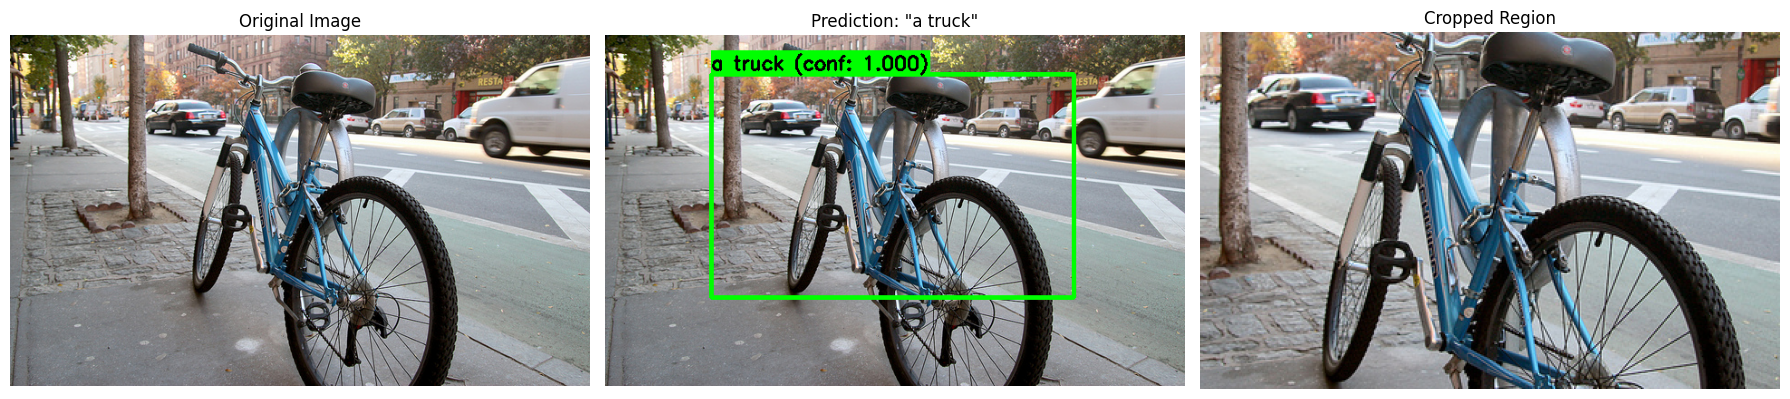

In [19]:
def create_kaggle_demo():
    
    def predict_and_visualize(image, query):
        try:
            bbox, confidence, attention_weights = inference_system.predict(image, query)
            
            result_img, cropped = inference_system.visualize_prediction(
                image, query, bbox, confidence
            )
            
            return result_img, cropped if cropped is not None else image
            
        except Exception as e:
            print(f"Error in prediction: {e}")
            return np.array(image), np.array(image)
    
    #sample queries
    sample_queries = [
        "person", "car", "bicycle", "dog", "cat", "chair", "dining table",
        "laptop", "cell phone", "book", "bottle", "cup", "bowl", "banana",
        "apple", "sandwich", "pizza", "donut", "cake", "bird", "horse",
        "sheep", "cow", "elephant", "bear", "zebra", "giraffe"
    ]
    
    for i, query in enumerate(sample_queries[:10], 1):
        print(f"{i}. {query}")
    
    return predict_and_visualize

def test_with_validation_samples():
    print("Testing with validation samples...")
    
    try:
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        test_dataset = COCOSceneLocalizationDataset(
            split="val",
            transform=val_transform,
            max_samples=5
        )
        
        for i in range(min(5, len(test_dataset))):
            sample = test_dataset[i]
            
            img_path = test_dataset.img_dir / sample['file_name']
            original_image = Image.open(img_path).convert('RGB')
            
            print(f"\nTest {i+1}:")
            print(f"Query: '{sample['query']}'")
            print(f"Category: {sample['category']}")
            print(f"Ground truth bbox: {sample['bbox']}")
            
            pred_bbox, confidence, _ = inference_system.predict(original_image, sample['query'])
            print(f"Predicted bbox: {pred_bbox}")
            print(f"Confidence: {confidence:.3f}")
            
            inference_system.visualize_prediction(
                original_image, sample['query'], pred_bbox, confidence
            )
            
    except Exception as e:
        print(f"Error in testing: {e}")

demo_function = create_kaggle_demo()

test_with_validation_samples()


# Single Image prediction

Query: 'balloon'
Predicted bbox: [0.408, 0.345, 0.578, 0.547]
Confidence: 1.000


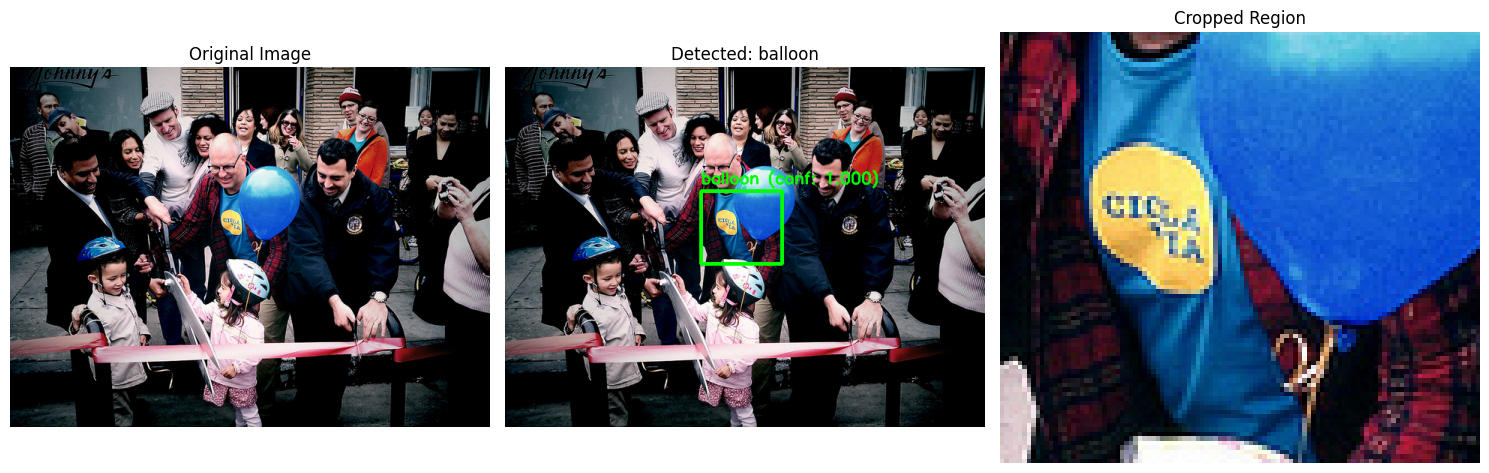

In [35]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from transformers import CLIPProcessor

def load_and_predict(image_path, query_text, model, device='cuda'):
    image = Image.open(image_path).convert('RGB')
    
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    inputs = clip_processor(
        text=[query_text],
        images=[image],
        return_tensors="pt",
        padding=True
    )
    
    pixel_values = inputs['pixel_values'].to(device)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    model.eval()
    
    with torch.no_grad():
        bbox_pred, class_pred, confidence, attention_weights = model(
            pixel_values, input_ids, attention_mask
        )
    
    bbox = bbox_pred[0].cpu().numpy()  
    conf = confidence[0].cpu().numpy()[0]
    
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    
    x1, y1, x2, y2 = bbox
    x1, x2 = int(x1 * w), int(x2 * w)
    y1, y2 = int(y1 * h), int(y2 * h)
    
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    img_with_bbox = img_array.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    label = f"{query_text} (conf: {conf:.3f})"
    cv2.putText(img_with_bbox, label, (x1, y1-10), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    cropped_region = img_array[y1:y2, x1:x2] if x2 > x1 and y2 > y1 else None
    
    return bbox, conf, img_with_bbox, cropped_region

def demo_single_prediction():
    image_path = "/kaggle/input/coco-2017-dataset/coco2017/val2017/000000005001.jpg"
    query = "balloon"  
    
    bbox, confidence, result_image, cropped = load_and_predict(
        image_path, query, model, device='cuda'
    )
    
    print(f"Query: '{query}'")
    print(f"Predicted bbox: [{bbox[0]:.3f}, {bbox[1]:.3f}, {bbox[2]:.3f}, {bbox[3]:.3f}]")
    print(f"Confidence: {confidence:.3f}")
    
    plt.figure(figsize=(15, 5))
    
    original = Image.open(image_path)
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(result_image)
    plt.title(f'Detected: {query}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    if cropped is not None:
        plt.imshow(cropped)
        plt.title('Cropped Region')
    else:
        plt.text(0.5, 0.5, 'No valid region', ha='center', va='center')
        plt.title('Cropped Region (Invalid)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return bbox, confidence, result_image, cropped

bbox, conf, result_img, cropped = demo_single_prediction()


# Save Model

In [21]:
def save_model_for_kaggle(model, save_dir="./model_outputs"):
    """Save the trained model and metadata"""
    os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, "coco_scene_localization_model.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'num_classes': 80,
        },
        'clip_model_name': "openai/clip-vit-base-patch32"
    }, model_path)
    
    metadata = {
        'model_architecture': 'EnhancedSceneLocalizationModel',
        'base_model': 'CLIP ViT-B/32',
        'dataset': 'COCO 2017',
        'task': 'Scene Localization via Natural Language',
        'input_size': [224, 224],
        'output_format': 'normalized_bbox [x1, y1, x2, y2]',
        'categories': 80,
        'training_samples': 'up to 1000 (limited for Kaggle)',
        'validation_samples': 'up to 200 (limited for Kaggle)'
    }
    
    metadata_path = os.path.join(save_dir, "model_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    usage_code = '''
# Load the trained model
import torch
from transformers import CLIPModel, CLIPProcessor

# Load model
checkpoint = torch.load("coco_scene_localization_model.pth")
model = EnhancedSceneLocalizationModel(num_classes=80)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Initialize inference
inference = COCOSceneLocalizationInference(model)

# Use the model
from PIL import Image
image = Image.open("your_image.jpg")
query = "person"
bbox, confidence, attention = inference.predict(image, query)
print(f"Predicted bbox: {bbox}, Confidence: {confidence}")
'''
    
    usage_path = os.path.join(save_dir, "usage_example.py")
    with open(usage_path, 'w') as f:
        f.write(usage_code)
    
    print(f"Model saved to {save_dir}")
    print(f"Files created:")
    print(f"  - {model_path}")
    print(f"  - {metadata_path}")
    print(f"  - {usage_path}")

def create_submission_notebook():
    notebook_content = {
        "cells": [
            {
                "cell_type": "markdown",
                "metadata": {},
                "source": [
                    "# Scene Localization in Dense Images via Natural Language Queries\n",
                    "\n",
                    "This notebook implements a scene localization system using the COCO 2017 dataset.\n",
                    "The model can identify and localize specific objects/activities in images based on natural language descriptions.\n",
                    "\n",
                    "## Key Features:\n",
                    "- CLIP-based vision-language model\n",
                    "- Cross-modal attention fusion\n",
                    "- COCO 2017 dataset integration\n",
                    "- Real-time inference capabilities"
                ]
            }
        ]
    }
    
    return notebook_content

save_model_for_kaggle(model)



Model saved to ./model_outputs
Files created:
  - ./model_outputs/coco_scene_localization_model.pth
  - ./model_outputs/model_metadata.json
  - ./model_outputs/usage_example.py
